In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import pybullet as p
import pybullet_data 
import time
import torch
import torch.nn as nn
import torch.optim as optim
import math
import random
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
physicsClient = p.connect(p.GUI)
p.setGravity(0,0,-10) 
p.resetSimulation() 
p.setAdditionalSearchPath(pybullet_data.getDataPath()) 
planeId = p.loadURDF("plane.urdf") 
robotId = p.loadURDF("iiwa7.urdf",flags=9, useFixedBase=1)

robotStartPos = [0,0,0]
robotStartOrientation = p.getQuaternionFromEuler([0,0,0])

p.resetBasePositionAndOrientation(robotId,robotStartPos,robotStartOrientation)

p.setJointMotorControlArray(robotId,range(7),p.VELOCITY_CONTROL,forces=np.zeros(7))

def simulate_system1(x, u):
    x_next=[]
    for i in range(7):
        p.resetJointState(robotId,i,x[i],targetVelocity = x[i+7])
    
    p.setJointMotorControlArray(robotId,range(7), controlMode=p.TORQUE_CONTROL,forces=u)
    p.stepSimulation()
    for i in range(7):
        x_next.append(p.getJointStates(robotId,range(7))[i][0])
    for i in range(7):
        x_next.append(p.getJointStates(robotId,range(7))[i][1])
    x_next = np.array(x_next)
    return x_next

N=3000
x_data = np.zeros([14,N])
u_data= np.zeros([7, N])
x_new=np.zeros([14,N])
for i in range(N):
    for j in range(7):
        a=random.randint(-180,180)#angule range(-pi,pi)
        b=random.uniform(-10, 10)#velocity range
        c=random.randint(-30,30)#torque range (-200,200)
        x_data[j,i]=math.radians(a/math.pi)
        x_data[j+7,i]=b
        u_data[j,i]=c
            
for i in range(N):
    x_new[:,i]=simulate_system1(x_data[:,i], u_data[:,i])
        
x_data=x_data.T
u_data = u_data.T
x_train = np.append(x_data,u_data,axis=1)
y_train = x_new.T
x_train = x_train.astype(np.float32)
y_train=y_train.astype(np.float32)
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(21, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 14),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(21, 500)   # hidden layer
        self.predict = torch.nn.Linear(500, 14)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x


class MultiLinearRegression(nn.Module):
    def __init__(self):
        super(MultiLinearRegression, self).__init__()
        self.linear = nn.Linear(21,14)  
        self.hidden
    def forward(self,x):
        out = self.linear(x)
        return out

model = Net()

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

floss=[]
elist=[]
gradlist=[]
epoch = 0
while True:
    output = model(x_train)  
    loss = criterion(output, y_train)  
    loss_value = loss.data.cpu().numpy() 
    optimizer.zero_grad()  
    loss.backward()

    total_norm=0
    for k in model.parameters():
        param_norm = k.grad.data.norm(2)
        total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)
    gradlist.append(total_norm)
    optimizer.step() 
    
    epoch += 1
    if epoch % 1000 == 0: 
        print('Epoch:{}, loss:{:.6f}'.format(epoch, loss_value))
        floss.append(loss_value)
        elist.append(epoch)
    if loss_value <= 1e-1 :
        break


Epoch:1000, loss:1.015152
Epoch:2000, loss:0.906268
Epoch:3000, loss:0.847227
Epoch:4000, loss:0.804263
Epoch:5000, loss:0.769785
Epoch:6000, loss:0.741150
Epoch:7000, loss:0.716917
Epoch:8000, loss:0.695956
Epoch:9000, loss:0.677551
Epoch:10000, loss:0.661212
Epoch:11000, loss:0.646510
Epoch:12000, loss:0.633179
Epoch:13000, loss:0.620934
Epoch:14000, loss:0.609715
Epoch:15000, loss:0.599387
Epoch:16000, loss:0.589768
Epoch:17000, loss:0.580738
Epoch:18000, loss:0.572250
Epoch:19000, loss:0.564144
Epoch:20000, loss:0.556440
Epoch:21000, loss:0.549075
Epoch:22000, loss:0.541990
Epoch:23000, loss:0.535238
Epoch:24000, loss:0.528807
Epoch:25000, loss:0.522650
Epoch:26000, loss:0.516670
Epoch:27000, loss:0.510921
Epoch:28000, loss:0.505378
Epoch:29000, loss:0.500035
Epoch:30000, loss:0.494860
Epoch:31000, loss:0.489802
Epoch:32000, loss:0.484885
Epoch:33000, loss:0.480110
Epoch:34000, loss:0.475441
Epoch:35000, loss:0.470869
Epoch:36000, loss:0.466428
Epoch:37000, loss:0.462076
Epoch:3800

KeyboardInterrupt: 

In [6]:
def get_linearization(current_state, control_signal):
    eps = 1e-5
    A = np.zeros([len(current_state), len(current_state)])
    for ii in range(len(current_state)):
        x = current_state.copy()
        x[ii] += eps
        x_inc = simulate_system(x, control_signal)  
        x = current_state.copy()
        x[ii] -= eps
        x_dec = simulate_system(x, control_signal)
        A[:,ii] = (x_inc - x_dec) / (2 * eps)
 
    B = np.zeros([len(current_state), len(control_signal)])
    for ii in range(len(control_signal)):
        u = control_signal.copy()
        u[ii] += eps
        x_inc = simulate_system(current_state, u)
        u = control_signal.copy()
        u[ii] -= eps
        x_dec = simulate_system(current_state, u)
        B[:,ii] = (x_inc - x_dec) / (2 * eps)
    return A, B

def solve_ricatti_equations(Z,U,Q,R,N,q,r):
    
    
    K_gains = []
    k_feedforward = []
    S = Q[-1]
    s = q[-1]
       
    for i in reversed(range(horizon_length)):
        A, B = get_linearization(Z[:,i], U[:,i])
        W = np.linalg.inv(Sigma)-sigma*C.T.dot(S).dot(C)
        iW = np.linalg.inv(W)
        term_covar = C.dot(iW).dot(C.T)
        H = R + B.T.dot(S).dot(B) + sigma * B.T.dot(S.T).dot(term_covar).dot(S).dot(B)
        g = r[i] + B.T.dot(s) + sigma * B.T.dot(S.T).dot(term_covar).dot(s)
        G = B.T.dot(S).dot(A) + sigma * B.T.dot(S.T).dot(term_covar.T).dot(S).dot(A)
        k = -np.linalg.solve(H,g)
        K = -np.linalg.solve(H,G)
        s = q[i] + A.T.dot(s) + G.T.dot(k) + K.T.dot(g) + K.T.dot(H).dot(k) + sigma * A.T.dot(S.T).dot(term_covar).dot(s)
        S = Q[i] + A.T.dot(S).dot(A) + K.T.dot(H).dot(K) + G.T.dot(K) + K.T.dot(G) + sigma * A.T.dot(S.T).dot(term_covar).dot(S).dot(A)
      
        K_gains.append(K)
        k_feedforward.append(k)
        
       
    K_gains = K_gains[::-1]
    k_feedforward = k_feedforward[::-1]
    return K_gains, k_feedforward

def controller(Z,U,q,r,horizon_length,Q,R,alpha):
    state2=np.empty([14, horizon_length+1])
    z0 = np.zeros([14,])
    state2[:,0] = z0
    u2 = np.zeros([7, horizon_length])
    K,k = solve_ricatti_equations(Z,U,Q,R,horizon_length,q,r)
    for i in range(horizon_length):
        u2[:,i] = U[:,i] + K[i] @ (state2[:,i] - Z[:,i])+ alpha*k[i]
        state2[:,i+1] = simulate_system(state2[:,i], u2[:,i])
   
    state=state2.copy()
    u=u2.copy()
    return state,u,k

def compute_cost(Z,U,z_bar,u_bar, horizon_length):
    J=((Z[:,horizon_length]-z_bar[:,horizon_length]).T)@ Q[horizon_length] @(Z[:,horizon_length]-z_bar[:,horizon_length])
    for i in range(horizon_length):
        J=J+((Z[:,i]-z_bar[:,i]).T)@ Q[i] @(Z[:,i]-z_bar[:,i])+((U[:,i]-u_bar[:,i]).T @ R @ (U[:,i]-u_bar[:,i]))
    
    return J

def get_quadratic_approximation_cost(Z,U, horizon_length,z_bar,u_bar):
    q=[]
    r=[]
    J=compute_cost(Z,U,z_bar,u_bar, horizon_length)
    #J=J+0.5*((z[:,horizon_length]-Z[:,horizon_length]).T)@ Q[horizon_length] @(z[:,horizon_length]-Z[:,horizon_length])+2*(z[:,horizon_length].T-z_bar[:,horizon_length].T)@Q[horizon_length]@(z[:,horizon_length]-Z[:,horizon_length])
    for i in range(horizon_length):
        #J=J+0.5*((u[:,i]-U[:,i]).T)@ R @(u[:,i]-U[:,i])+0.5*((z[:,i]-Z[:,i]).T)@ Q[i] @(z[:,i]-Z[:,i])+2*((z[:,i]-z_bar[:,i]).T)@Q[i]@(z[:,i]-Z[:,i])+2*((u[:,i]-u_bar[:,i]).T)@R@(u[:,i]-U[:,i])    
        q1=2*(Z[:,i]-z_bar[:,i]).T@Q[i]
        q.append(q1)
        r1=2*(U[:,i]-u_bar[:,i]).T@R
        r.append(r1)
    
    return q,r

In [186]:
a=1
horizon_length = 40
Q2=0.1*np.eye(14)
Q1=1000*np.eye(14)
for i in range(7,14):
    Q1[i,i]=0.1
Q=[]
for i in range(horizon_length+1):
    if (i==horizon_length):
        Q.append(Q1)
    else:
        Q.append(Q2)

R=0.01*np.eye(7)
sigma=0
C=np.eye(14)
Sigma=1*np.eye(14)


u_bar = np.zeros([7, horizon_length])
U = np.zeros([7, horizon_length])
Z = np.zeros([14,horizon_length+1])
u= np.zeros([7, horizon_length])
   
z_bar=np.zeros([14,horizon_length+1])
target_p = np.array([-1.5,0.3,0.5])
robotEndOrientation = p.getQuaternionFromEuler([1,0,2])
targetPositionsJoints = p.calculateInverseKinematics(robotId,7,target_p,targetOrientation = robotEndOrientation)
p.setJointMotorControlArray(robotId,range(7),p.POSITION_CONTROL,targetPositions = targetPositionsJoints)
z_bar[0:7,horizon_length]=targetPositionsJoints



In [178]:
def simulate_system(x, u):
    x = x.T
    u = u.T
    x = np.hstack((x,u))
    x = x.astype(np.float32)
    x = torch.from_numpy(x)
    x_next = model(x)
    x_next=x_next.detach().numpy()
    return x_next
    
    

In [187]:
def simulate_system(x, u):
    x_next=[]
    for i in range(7):
        p.resetJointState(robotId,i,x[i],targetVelocity = x[i+7])
    
    p.setJointMotorControlArray(robotId,range(7), controlMode=p.TORQUE_CONTROL,forces=u)
    p.stepSimulation()
    for i in range(7):
        x_next.append(p.getJointStates(robotId,range(7))[i][0])
    for i in range(7):
        x_next.append(p.getJointStates(robotId,range(7))[i][1])
    x_next = np.array(x_next)
    return x_next

In [188]:
q,r=get_quadratic_approximation_cost(Z,U, horizon_length,z_bar,u_bar)
state,u,k = controller(Z,U,q,r,horizon_length,Q,R,a)
U = u
Z = np.zeros([14, horizon_length+1])
for i in range(horizon_length):
    Z[:,i+1] = simulate_system(Z[:,i], U[:,i])
J=compute_cost(Z,U,z_bar,u_bar, horizon_length)
J1=J
print(J)

q,r=get_quadratic_approximation_cost(Z,U, horizon_length,z_bar,u_bar)
state,u,k = controller(Z,U,q,r,horizon_length,Q,R,a)
U = u
Z = np.zeros([14, horizon_length+1])
for i in range(horizon_length):
    Z[:,i+1] = simulate_system(Z[:,i], U[:,i])
J=compute_cost(Z,U,z_bar,u_bar, horizon_length)
J1=J
print(J)

for j in range(3000):
    q,r=get_quadratic_approximation_cost(Z,U, horizon_length,z_bar,u_bar)
    state,u,k = controller(Z,U,q,r,horizon_length,Q,R,a)
    U = u
    Z = np.zeros([14, horizon_length+1])
    for i in range(horizon_length):
        Z[:,i+1] = simulate_system(Z[:,i], U[:,i])
    J=compute_cost(Z,U,z_bar,u_bar, horizon_length)
    print(J)
    if (J<=J1):
        if (abs(J1-J)<0.1):
            print("iteration converged")
            break
        J1=J
    else:
        a=a/2
        J1=J
        print(a)

8815.214047517038
8815.214051206241
8815.2140475217
iteration converged


In [189]:
Z_trained=[]
Z_true=[]
x = np.zeros([14,1])
for i in range(7):
    p.resetJointState(robotId,i,x[i],targetVelocity = x[i+7])
for i in range(horizon_length):
    p.setJointMotorControlArray(robotId,range(7), controlMode=p.TORQUE_CONTROL,forces= u[:,i])
    p.stepSimulation()
for i in range(7):
    Z_trained.append(p.getJointStates(robotId,range(7))[i][0])
Z_trained=np.array(Z_trained[0:7])
Z_true=np.array(targetPositionsJoints)

print(Z_trained)
print(Z_true)

[-2.92288190e+00  1.45803789e+00  2.18166708e+00  3.15069796e-04
  1.55549624e+00  1.99900713e+00  2.29338187e+00]
[-3.28862920e+00  1.47999105e+00  2.21434435e+00  2.63123146e-04
  1.57834456e+00  2.18942721e+00  2.37072893e+00]


In [190]:
error=0
for i in range(7):
    error=error + abs(Z_trained[i]-Z_true[i])
print(error)

0.7110451298300033


In [191]:
error_model=np.array([0.004230902930731069,0.5122089806924557,0.12439047884806284,1.9344235549753812,5.87841776987318,1.2982794037943128,4.536704419292526,4.423781966041569,0.11336095883911418,0.7224809518133458])
error_ilqr=np.array([0.00406744666863552,0.5101985873524963,0.1227792124961957,1.9095306168655066,5.928990298719336,1.5048065685542873,3.659379847303185,4.030355246241443,0.11865553041000271,0.7110451298300033])

<IPython.core.display.Javascript object>


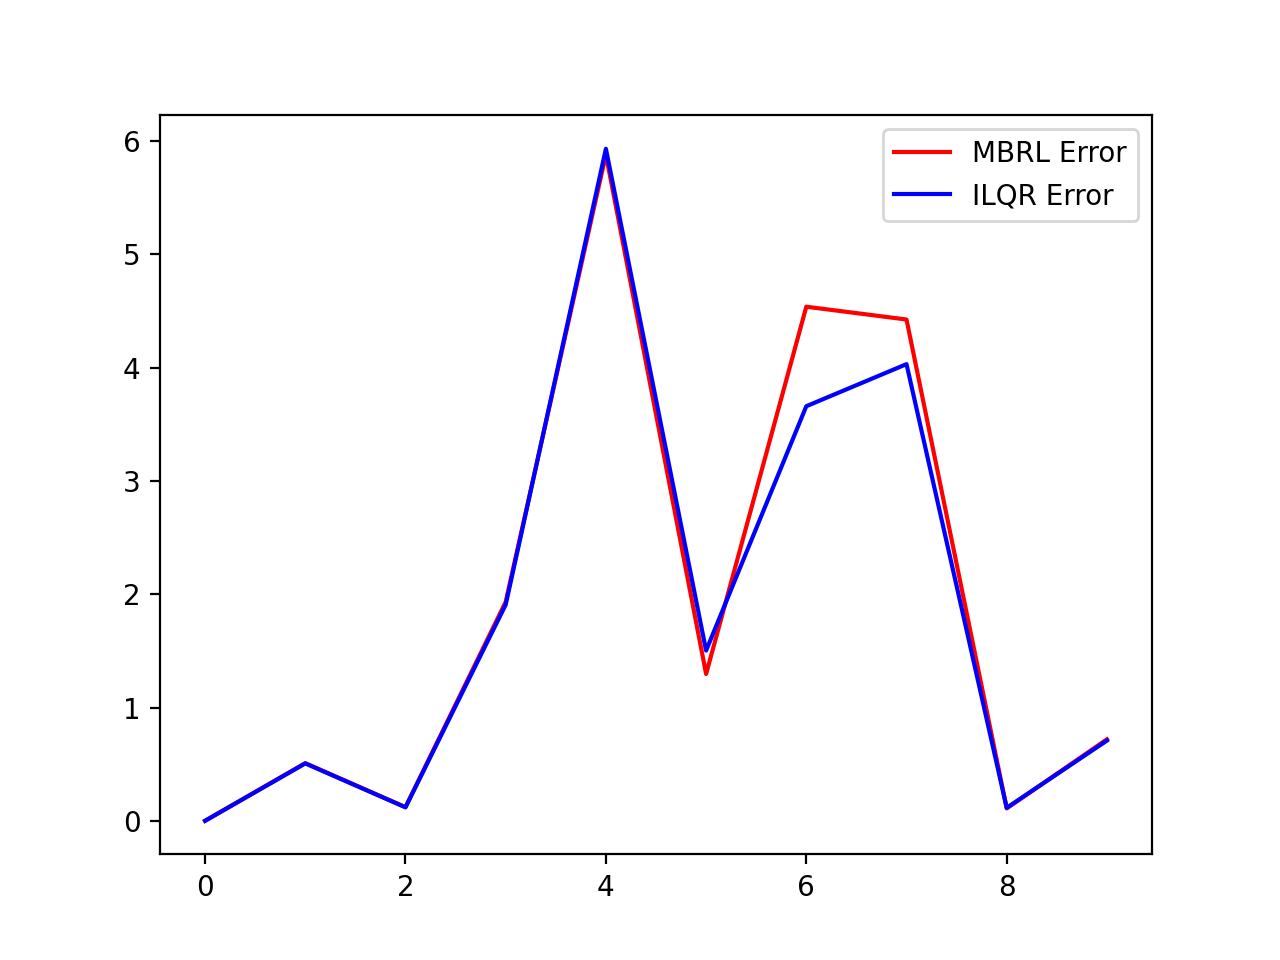

In [197]:
n= [i for i in range(10)]
plt.figure()
line1,=plt.plot(n,error_model,color='red',label='MBRL Error')
line2,=plt.plot(n,error_ilqr,color='blue',label='ILQR Error')
plt.legend(handles=[line1, line2])

In [109]:
x_true=Z_true
x_trained=Z_trained

In [121]:
x_true=np.vstack((x_true,Z_true))
x_trained=np.vstack((x_trained,Z_trained))
print(x_true)
print(x_trained)

[[ 8.33007297e-01  1.64866365e+00 -6.59352246e-01  1.62996239e-02
  -2.48264160e+00  1.56713246e+00 -9.85049141e-01]
 [ 8.37747628e-01  1.64257018e+00 -6.59165537e-01  7.65734290e-04
  -2.48244612e+00  1.57387121e+00 -9.79831196e-01]]
[[ 7.79928330e-01  1.49703201e+00 -1.49499607e+00  1.17601676e-01
  -1.63211172e+00  1.42071680e+00  2.23799484e+00]
 [ 8.37748033e-01  1.64257017e+00 -6.59165537e-01  7.59857640e-04
  -2.48243780e+00  1.57387380e+00 -9.79829677e-01]]


In [124]:
Z_ilqr=[]
for i in range(horizon_length):
    p.setJointMotorControlArray(robotId,range(7), controlMode=p.TORQUE_CONTROL,forces= u[:,i])
    p.stepSimulation()
for i in range(7):
    Z_ilqr.append(p.getJointStates(robotId,range(7))[i][0])
Z_ilqr=np.array(Z_trained[0:7])

In [125]:
x_ilqr=Z_ilqr
print(x_ilqr)

[ 8.37748033e-01  1.64257017e+00 -6.59165537e-01  7.59857640e-04
 -2.48243780e+00  1.57387380e+00 -9.79829677e-01]


In [ ]:
x_ilqr=np.vstack((x_ilqr,Z_true))

In [ ]:
plt.figure()
plt.subplot(5,3,1)
plt.plot(n,x_newtest[0,:],'o',n,ytrain_test[0,:],'^')
plt.subplot(5,3,2)
plt.plot(n,x_newtest[1,:],'o',n,ytrain_test[1,:],'^')
plt.subplot(5,3,3)
plt.plot(n,x_newtest[2,:],'o',n,ytrain_test[2,:],'^')
plt.subplot(5,3,4)
plt.plot(n,x_newtest[3,:],'o',n,ytrain_test[3,:],'^')
plt.subplot(5,3,5)
plt.plot(n,x_newtest[4,:],'o',n,ytrain_test[4,:],'^')
plt.subplot(5,3,6)
plt.plot(n,x_newtest[5,:],'o',n,ytrain_test[5,:],'^')
plt.subplot(5,3,7)
plt.plot(n,x_newtest[6,:],'o',n,ytrain_test[6,:],'^')
plt.subplot(5,3,8)
plt.plot(n,x_newtest[7,:],'o',n,ytrain_test[7,:],'^')
plt.subplot(5,3,9)
plt.plot(n,x_newtest[8,:],'o',n,ytrain_test[8,:],'^')
plt.subplot(5,3,10)
plt.plot(n,x_newtest[9,:],'o',n,ytrain_test[9,:],'^')

In [47]:
x = np.zeros([14,1])
for i in range(7):
    p.resetJointState(robotId,i,x[i],targetVelocity = x[i+7])

In [95]:
for i in range(horizon_length):
    p.setJointMotorControlArray(robotId,range(7), controlMode=p.TORQUE_CONTROL,forces= u[:,i])
    p.stepSimulation()

In [48]:
xe=[]
ye=[]
ze=[]
for i in range(horizon_length):
    p.setJointMotorControlArray(robotId,range(7), controlMode=p.TORQUE_CONTROL,forces= u[:,i])
    xe.append(p.getLinkState(robotId,7)[0][0])
    ye.append(p.getLinkState(robotId,7)[0][1])
    ze.append(p.getLinkState(robotId,7)[0][2])
    p.stepSimulation()

In [34]:
x1=xe
y1=ye
z1=ze

In [44]:
x2=xe
y2=ye
z2=ze

In [49]:
x3=xe
y3=ye
z3=ze

<IPython.core.display.Javascript object>


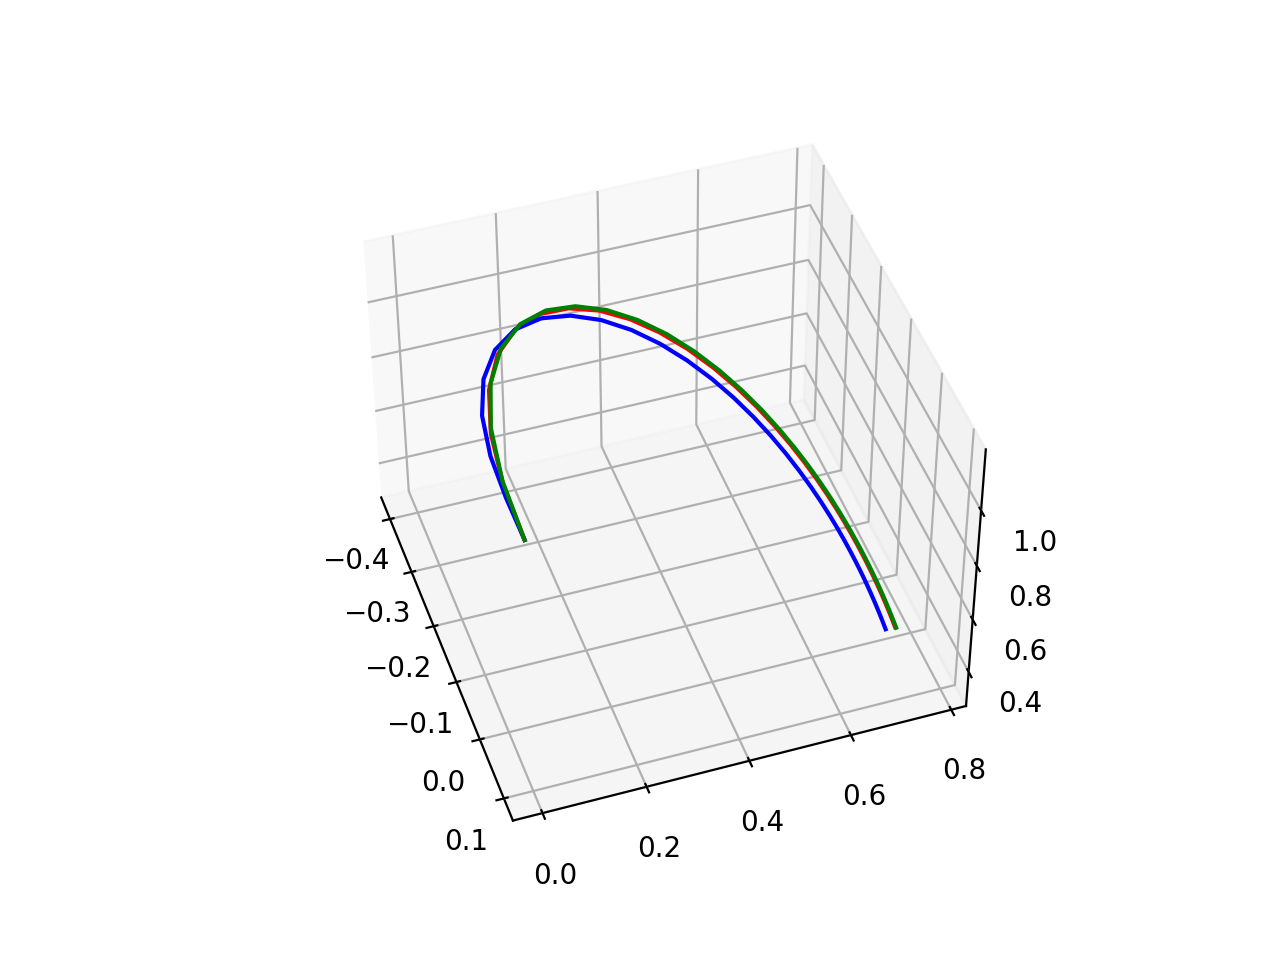

In [23]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# Data for a three-dimensional line
ax.plot3D(x1, y1, z1, c='r')
ax.plot3D(x2, y2, z2, c='b')
ax.plot3D(x3, y3, z3, c='g')

<IPython.core.display.Javascript object>


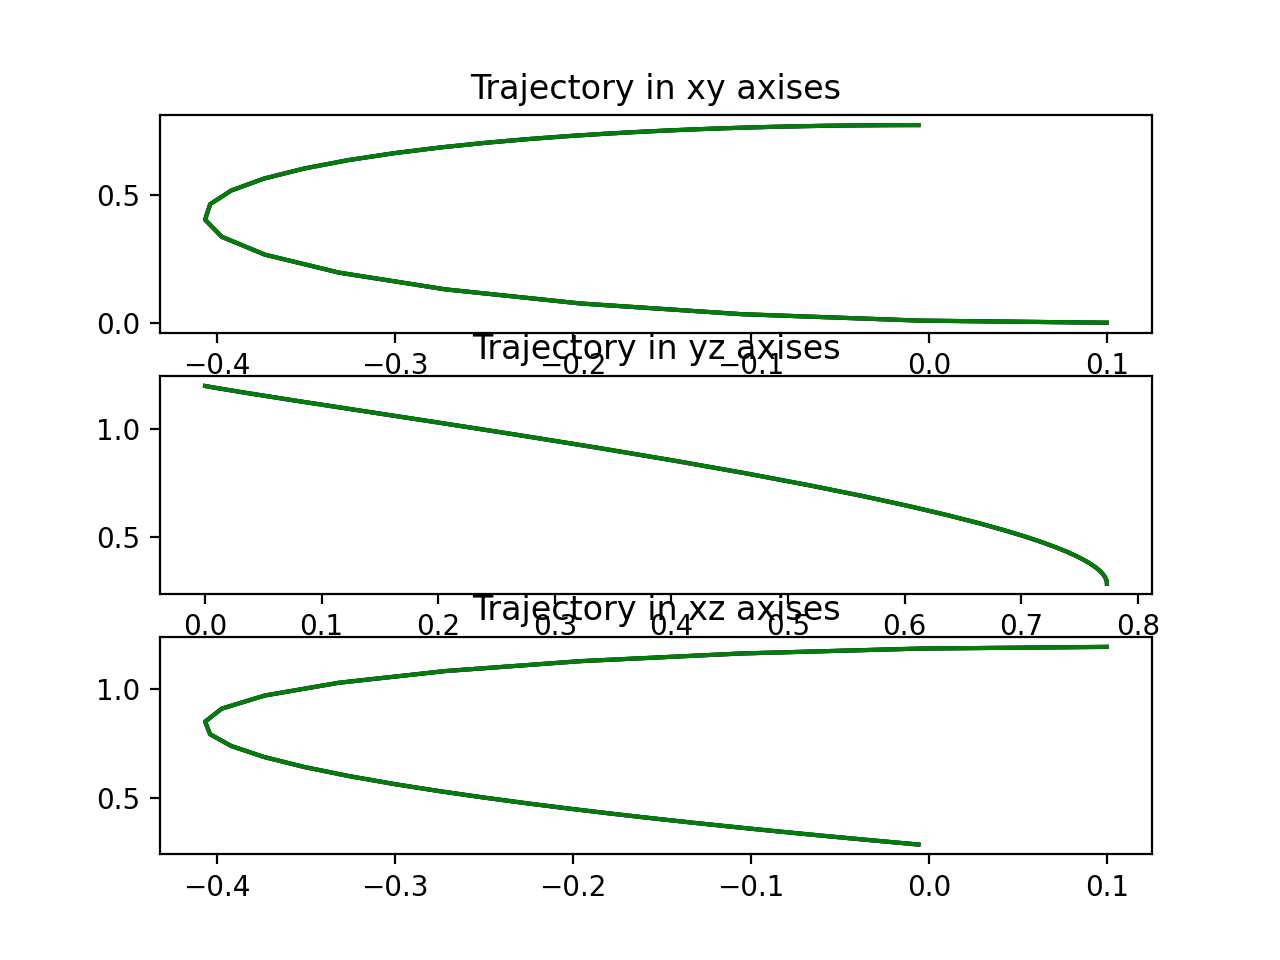

Text(0.5, 1.0, 'Trajectory in xz axises')

In [50]:
plt.figure()
plt.subplot(3,1,1)
plt.plot(x1,y1,'r',x2,y2,'b',x3,y3,'g')
plt.title('Trajectory in xy axises')
plt.subplot(3,1,2)
plt.plot(y1,z1,'r',y2,z2,'b',y3,z3,'g')
plt.title('Trajectory in yz axises')
plt.subplot(3,1,3)
plt.plot(x1,z1,'r',x2,z2,'b',x3,z3,'g')
plt.title('Trajectory in xz axises')